In [76]:
import polars as pl
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
import geodatasets
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [50]:
lf = pl.scan_csv("data/GlobalWeatherRepository.csv")
dropped_columns = [
                   "country", # country can be derived from location_name
                   "timezone", # timezone can be derived from location_name
                   "last_updated", # last_updated can be derived from last_updated_epoch
                   "temperature_fahrenheit", # temperature_fahrenheit can be derived from temperature_celsius
                   "condition_text", # condition_text could be used for a classification problem, but we're shooting for 
                   "wind_mph", # wind_mph can be derived from wind_kph
                   "wind_direction", # wind_direction can be derived from wind_degree
                   "pressure_in", # pressure_in can be derived from pressure_mb
                   "precip_in",  # precip_in can be derived from precip_mm
                   "feels_like_fahrenheit", # feels_like_fahrenheit can be derived from feels_like_celsius. Study will be done on correlations to find if feels_like_celsius is too correlated with temperature_celsius
                   "visibility_miles", # visibility_miles can be derived from visibility_km
                   "gust_mph", # gust_mph can be derived from gust_kph
                   "air_quality_Carbon_Monoxide", # Dropping all air quality metrics - these should be their own forecasting project
                   "air_quality_Ozone",
                   "air_quality_Nitrogen_dioxide",
                   "air_quality_Sulphur_dioxide",
                   "air_quality_PM2.5",
                   "air_quality_PM10",
                   "air_quality_us-epa-index",
                   "air_quality_gb-defra-index"
                  ]

In [51]:
lf = lf.drop(dropped_columns)
lf.collect()

location_name,latitude,longitude,last_updated_epoch,temperature_celsius,wind_kph,wind_degree,pressure_mb,precip_mm,humidity,cloud,feels_like_celsius,visibility_km,uv_index,gust_kph,sunrise,sunset,moonrise,moonset,moon_phase,moon_illumination
str,f64,f64,i64,f64,f64,i64,f64,f64,i64,i64,f64,f64,f64,f64,str,str,str,str,str,i64
"""Kabul""",34.52,69.18,1715849100,26.6,13.3,338,1012.0,0.0,24,30,25.3,10.0,7.0,15.3,"""04:50 AM""","""06:50 PM""","""12:12 PM""","""01:11 AM""","""Waxing Gibbous""",55
"""Tirana""",41.33,19.82,1715849100,19.0,11.2,320,1012.0,0.1,94,75,19.0,10.0,5.0,18.4,"""05:21 AM""","""07:54 PM""","""12:58 PM""","""02:14 AM""","""Waxing Gibbous""",55
"""Algiers""",36.76,3.05,1715849100,23.0,15.1,280,1011.0,0.0,29,0,24.6,10.0,5.0,22.3,"""05:40 AM""","""07:50 PM""","""01:15 PM""","""02:14 AM""","""Waxing Gibbous""",55
"""Andorra La Vella""",42.5,1.52,1715849100,6.3,11.9,215,1007.0,0.3,61,100,3.8,2.0,2.0,13.7,"""06:31 AM""","""09:11 PM""","""02:12 PM""","""03:31 AM""","""Waxing Gibbous""",55
"""Luanda""",-8.84,13.23,1715849100,26.0,13.0,150,1011.0,0.0,89,50,28.7,10.0,8.0,20.2,"""06:12 AM""","""05:55 PM""","""01:17 PM""","""12:38 AM""","""Waxing Gibbous""",55
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""Caracas""",10.5,-66.9167,1751359500,25.0,7.2,157,1015.0,0.0,79,0,28.2,2.0,0.0,14.4,"""06:10 AM""","""06:53 PM""","""11:37 AM""","""11:54 PM""","""Waxing Crescent""",34
"""Hanoi""",21.0333,105.85,1751359500,29.2,10.1,108,1003.0,0.73,79,75,33.5,10.0,3.2,13.6,"""05:19 AM""","""06:42 PM""","""10:41 AM""","""11:06 PM""","""Waxing Crescent""",30
"""Sanaa""",15.3547,44.2067,1751359500,26.5,9.4,49,1011.0,0.0,16,47,24.9,10.0,11.5,10.8,"""05:37 AM""","""06:38 PM""","""10:57 AM""","""11:19 PM""","""Waxing Crescent""",31


<Axes: >

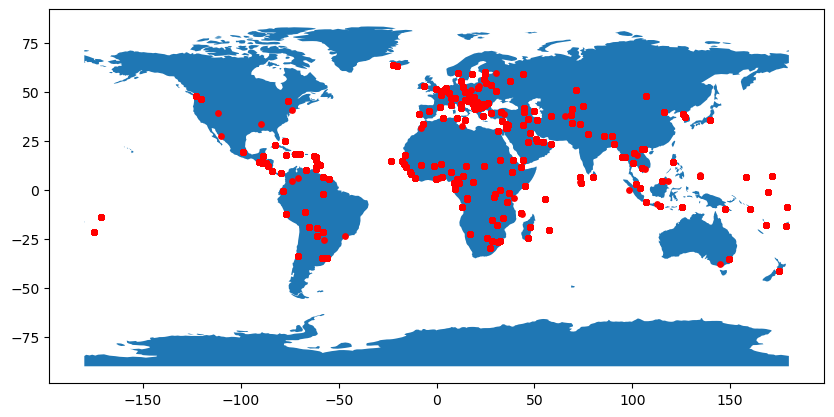

In [52]:
lon_lat = lf.select(["latitude", "longitude"])
geometry = [Point(xy) for xy in zip(lon_lat.select("longitude").collect().to_series(), lon_lat.select("latitude").collect().to_series())]
gdf = GeoDataFrame(lon_lat.collect(), geometry=geometry)
world = gpd.read_file(geodatasets.data.naturalearth.land['url'])
gdf.plot(ax=world.plot(figsize=(10, 6)), marker='o', color='red', markersize=15)

In [54]:
random_loc = lf.select("location_name").unique().collect().sample(n=1).row(0)[0]
random_loc_lf = lf.filter(pl.col("location_name") == random_loc).drop("location_name", "sunrise", "sunset", "moonrise", "moonset", "moon_phase").collect()
correlation_matrix = random_loc_lf.corr()

In [104]:
lf.drop("sunrise", "sunset", "moonrise", "moonset", "moon_phase").group_by("location_name").agg(
    [pl.corr("latitude", "latitude"), pl.corr("longitude", "longitude")]
).collect()

location_name,latitude,longitude
str,f64,f64
"""Phnum Penh""",NaN,NaN
"""Ho Chi Minh City""",NaN,NaN
"""Kingston""",NaN,NaN
"""Nouakchott""",1.0,1.0
"""Conakry""",1.0,1.0
…,…,…
"""National""",1.0,1.0
"""Sao Paulo""",NaN,NaN
"""Nassau""",1.0,1.0


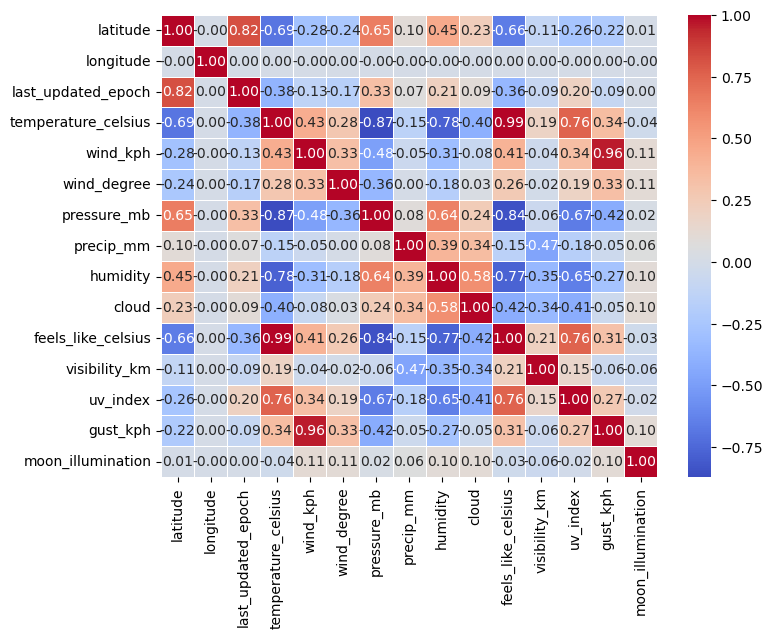

In [93]:
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5)
columns = random_loc_lf.collect_schema().names()
initial_values = np.asarray(range(len(columns))) + 0.5
plt.xticks(initial_values, columns, rotation="vertical")
plt.yticks(initial_values, columns, rotation="horizontal")
plt.show()